# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [1]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits
from astropy.visualization import simple_norm

In [2]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/UGC04416/aUGC04416_V.fits')
data = hdu['PRIMARY'].data

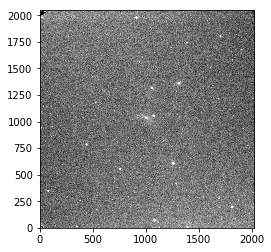

In [4]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=30, vmax=36)

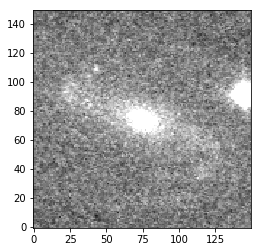

In [5]:
#cut
from astropy.nddata import Cutout2D
position = (1002, 1037)
size=(150,150)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=30, vmax=36)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [6]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

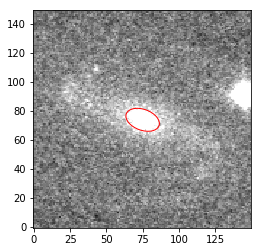

In [11]:
# how does it look?
geometry = EllipseGeometry (x0=75, y0=74, sma=12, eps=0.6,pa=160*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=30, vmax=36)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [12]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [13]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,21.06176072358672,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5166811717610944,20.832287708022726,0.020438542513070503,0.7300900143162791,0.011341862651542346,93.9804551536,0.748522019386,0.7976396086540597,13,0,10,0
0.5683492889372038,20.803505052411534,0.01884591513185033,0.7384005930563511,0.007037180434161911,94.5364898862,0.462189131236,0.5812179424906355,13,0,20,0
0.6251842178309243,20.56676617689707,0.04096696624872572,0.5740529382907834,0.01589870778628223,96.9480426327,1.1883467104,0.6071970916393041,13,0,17,0
0.6877026396140167,20.193627596596777,0.043661970168232554,0.3446750704615591,0.015899213290043755,102.951755047,1.70493996833,0.38115553776389544,13,0,11,0
0.7564729035754184,19.89734334678465,0.05749870554785017,0.2152892365390432,0.01955747768390631,115.214380645,3.11422591901,0.3571627698288737,13,0,10,0
0.8321201939329602,19.604193908745245,0.0468053919094964,0.1652356611303819,0.014128198830808453,131.99673727,2.85118953695,0.2279989572467495,13,0,10,0
0.9153322133262562,19.327479919270125,0.05450939672642098,0.1579668420840127,0.013596375733693425,136.85993073,2.85913663646,0.20422935791410085,13,0,10,0


Text(0,0.5,'Ellipticity')

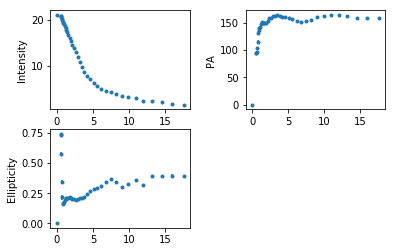

In [14]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [15]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5,1,'Residual')

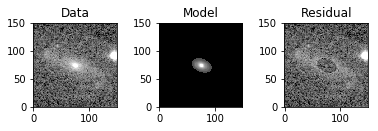

In [16]:
norm_model = simple_norm(model_image,stretch='asinh',percent=99.9)
norm_data = simple_norm(cutout.data,stretch='asinh',percent=98.5)
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower', norm=norm_data)
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', norm=norm_model)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', norm=norm_data)
ax3.set_title('Residual')